In [3]:
import gymnasium as gym
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)

In [4]:
import copy
import pylab
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import argparse, pdb
import numpy as np
import os
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.distributions import Categorical

In [5]:
class REINFORCE(nn.Module):
    def __init__(self, state_size, action_size):
        super(REINFORCE, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc_out = nn.Linear(64, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_out(x)
        return x

class REINFORCEAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # 하이퍼 파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001

        self.steps_done = 0

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = REINFORCE(self.state_size, self.action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        self.log_probs = []
        self.rewards = []

    # Policy에 따른 action 선택
    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(self.device)

        logits = self.model(state)[0]
        dist = Categorical(logits=logits)
        action = dist.sample()

        self.log_probs.append(dist.log_prob(action))
        return action.item()
    
    def discounted_return(self, rewards):
        returns = torch.zeros(len(rewards))
        running_add = 0.0
        for t in reversed(range(len(rewards))):
            running_add = rewards[t] + self.discount_factor * running_add
            returns[t] = running_add
        return returns

    def train_model(self):
        returns = torch.tensor(self.discounted_return(self.rewards), dtype=torch.float32).to(self.device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        loss = []
        for log_prob, R in zip(self.log_probs, returns):
            loss.append(-log_prob * R)
        
        self.optimizer.zero_grad()
        loss = torch.stack(loss).mean()
        loss.backward()
        self.optimizer.step()

        self.log_probs = []
        self.rewards = []
        return loss

In [6]:
root = os.getcwd()
save_dir = root + '\saved_models\REINFORCE'
print(save_dir)

c:\Users\Lee\PythonWorkspace\RL\saved_models\REINFORCE


C:\Users\Lee\AppData\Local\Temp\ipykernel_27272\1186250256.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(self.discounted_return(self.rewards), dtype=torch.float32).to(self.device)


episode: 0.000000, score: -148.406001, loss: 0.003
episode: 1.000000, score: -68.053006, loss: -0.005
episode: 2.000000, score: -371.380701, loss: 0.008
episode: 3.000000, score: -61.735784, loss: -0.002
episode: 4.000000, score: -180.803678, loss: 0.006
episode: 5.000000, score: -98.600398, loss: -0.003
episode: 6.000000, score: -92.066126, loss: 0.004
episode: 7.000000, score: -341.575710, loss: 0.006
episode: 8.000000, score: -199.625123, loss: 0.000
episode: 9.000000, score: -251.154785, loss: -0.001
episode: 10.000000, score: 8.358324, loss: -0.003
episode: 11.000000, score: -138.724052, loss: 0.004
episode: 12.000000, score: -223.601975, loss: -0.004
episode: 13.000000, score: -157.935074, loss: -0.006
episode: 14.000000, score: -330.760520, loss: 0.003
episode: 15.000000, score: -154.824909, loss: -0.022
episode: 16.000000, score: -64.377621, loss: 0.005
episode: 17.000000, score: -138.352285, loss: -0.005
episode: 18.000000, score: -90.500819, loss: -0.003
episode: 19.000000, s

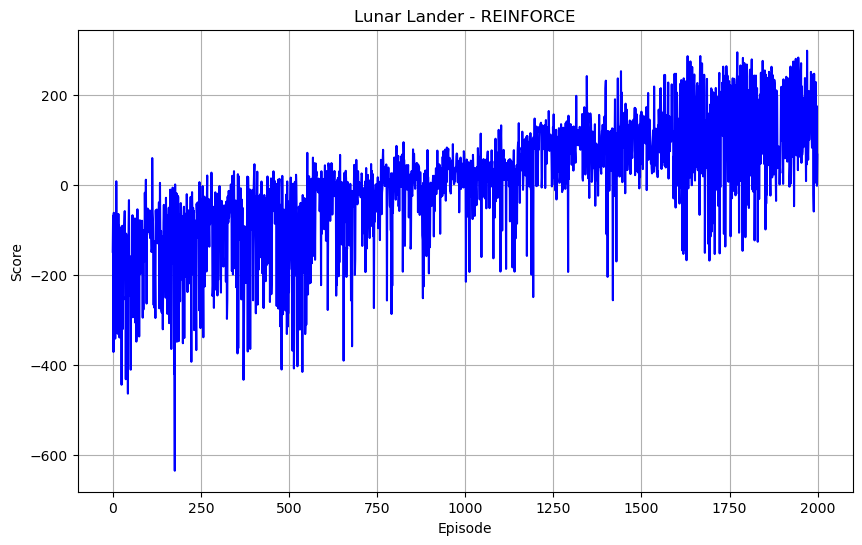

In [21]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = REINFORCEAgent(state_size, action_size)

scores, episodes = [], []

EPISODES = 2000
for e in range(EPISODES):
    done = False
    score = 0
    # env 초기화
    state, info = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done:
        # 현재 상태에 대한 행동 선택
        action = agent.get_action(state)

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        agent.rewards.append(reward)

        next_state = np.reshape(next_state, [1, state_size])
        
        score += reward
        state = next_state

        if done:
            loss = agent.train_model()
            print(f"episode: {e:3f}, score: {score:3f}, loss: {loss:.3f}")
            scores.append(score)
            episodes.append(e)

    # 100 에피소드마다 모델 저장
    if e > 0 and (e+1) % 100 == 0:
        file_name = f"lunar_lander_REINFORCE_ep{e+1}.pth"
        save_path = os.path.join(save_dir, file_name)
        torch.save(agent.model.state_dict(), save_path)
        print(f"--- Model saved at {save_path} ---")

plt.figure(figsize=(10, 6))
plt.plot(episodes, scores, 'b')
plt.title("Lunar Lander - REINFORCE")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.grid(True)
plt.show()

env.close()

In [10]:
MODEL_PATH = save_dir + "\lunar_lander_REINFORCE_ep2000.pth"

episodes_n = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode="human")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

model = REINFORCE(state_size, action_size).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

for e in range(episodes_n):
    state, info = env.reset()
    state = np.reshape(state, [1, state_size])

    done = False
    score = 0

    while not done:
        state_tensor = torch.FloatTensor(state).to(device)
        
        with torch.no_grad():
            logits = model(state_tensor)
            action = torch.argmax(F.softmax(logits, dim=1)).item()
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        score += reward
        state = np.reshape(next_state, [1, state_size])

    print(f"Episode {e+1}: Score = {score:.2f}")

env.close()

C:\Users\Lee\AppData\Local\Temp\ipykernel_13300\1828439572.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


Episode 1: Score = 210.31
Episode 2: Score = 174.87
Episode 3: Score = 55.26
